Electricity consumption forecasting is essential for optimizing power distribution, reducing energy waste, and ensuring a stable power supply. This project aimed to predict electricity usage using machine learning (Random Forest) and deep learning (LSTM) models.

The dataset included hourly electricity consumption, temperature, and time-based features such as the hour, day of the week, and month. After preprocessing the data, we tested both models. Random Forest performed better, achieving an MAE of 105.42 kWh and RMSE of 123.84 kWh, whereas LSTM had higher errors (MAE = 164.66, RMSE = 197.59), indicating poor generalization.

Key factors affecting electricity consumption were time of day, weather conditions, and seasonal variations. Peak usage occurred during morning and evening hours, while weekends had lower consumption.

The results show that Random Forest is a more reliable model for short-term forecasting, while LSTM requires improvements such as better feature scaling, longer sequences, and deeper architecture. Future enhancements could include XGBoost, Transformer-based models, and real-time data integration.

Overall, this study highlights the importance of choosing the right model and improving data representation to achieve accurate electricity demand predictions. 

Import all Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


 Load dataset 


In [4]:

df = pd.read_csv("electricity_consumption.csv", parse_dates=["timestamp"])

In [7]:
df.head()

,timestamp,consumption,temperature
0,2024-01-01 00:00:00,202,26.023771
1,2024-01-01 01:00:00,448,7.770907
2,2024-01-01 02:00:00,370,26.223842
3,2024-01-01 03:00:00,206,8.761608
4,2024-01-01 04:00:00,171,29.165754


In [8]:
df.tail

<bound method NDFrame.tail of                timestamp  consumption  temperature
0    2024-01-01 00:00:00          202    26.023771
1    2024-01-01 01:00:00          448     7.770907
2    2024-01-01 02:00:00          370    26.223842
3    2024-01-01 03:00:00          206     8.761608
4    2024-01-01 04:00:00          171    29.165754
...                  ...          ...          ...
8780 2024-12-31 20:00:00          314    10.635599
8781 2024-12-31 21:00:00          320    23.281053
8782 2024-12-31 22:00:00          488    -3.069635
8783 2024-12-31 23:00:00          141     2.690738
8784 2025-01-01 00:00:00          234    14.473789

[8785 rows x 3 columns]>

In [9]:
df.info

<bound method DataFrame.info of                timestamp  consumption  temperature
0    2024-01-01 00:00:00          202    26.023771
1    2024-01-01 01:00:00          448     7.770907
2    2024-01-01 02:00:00          370    26.223842
3    2024-01-01 03:00:00          206     8.761608
4    2024-01-01 04:00:00          171    29.165754
...                  ...          ...          ...
8780 2024-12-31 20:00:00          314    10.635599
8781 2024-12-31 21:00:00          320    23.281053
8782 2024-12-31 22:00:00          488    -3.069635
8783 2024-12-31 23:00:00          141     2.690738
8784 2025-01-01 00:00:00          234    14.473789

[8785 rows x 3 columns]>

In [10]:
# Load dataset (replace with your actual dataset)
df = pd.read_csv("electricity_consumption.csv", parse_dates=["timestamp"])

# Ensure the data is sorted by time
df = df.sort_values(by="timestamp")

# Feature Engineering
df["hour"] = df["timestamp"].dt.hour
df["day_of_week"] = df["timestamp"].dt.dayofweek
df["month"] = df["timestamp"].dt.month

# Handle missing values (if any)
df.fillna(method="ffill", inplace=True)

# Select features and target variable
features = ["hour", "day_of_week", "month", "temperature"]  # Add more features if available
target = "consumption"

# Normalize data
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])


C:\Users\muham\AppData\Local\Temp\ipykernel_22800\3334380320.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)


In [11]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
rf_preds = rf_model.predict(X_test)

# Evaluate
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))

print(f"Random Forest MAE: {rf_mae}")
print(f"Random Forest RMSE: {rf_rmse}")


Random Forest MAE: 105.4286909504838
Random Forest RMSE: 123.84185621266826


In [12]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define hyperparameter grid
param_grid = {
    "n_estimators": [50, 100, 200, 500],  # Number of trees
    "max_depth": [10, 20, 30, None],  # Maximum depth of trees
    "min_samples_split": [2, 5, 10],  # Minimum samples to split a node
    "min_samples_leaf": [1, 2, 4],  # Minimum samples per leaf node
}

# Initialize Random Forest
rf_model = RandomForestRegressor(random_state=42)

# Perform Randomized Search
rf_search = RandomizedSearchCV(rf_model, param_grid, n_iter=10, cv=3, scoring="neg_mean_absolute_error", n_jobs=-1)
rf_search.fit(X_train, y_train)

# Best model
best_rf = rf_search.best_estimator_

# Predict and evaluate
rf_preds = best_rf.predict(X_test)
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))

print(f"Optimized Random Forest MAE: {rf_mae}")
print(f"Optimized Random Forest RMSE: {rf_rmse}")



Optimized Random Forest MAE: 101.84860543479124
Optimized Random Forest RMSE: 118.13571712482313


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Prepare data for LSTM
sequence_length = 24

def create_sequences(data, target, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data.iloc[i:i + seq_length].values)
        labels.append(target.iloc[i + seq_length])
    return np.array(sequences), np.array(labels)

X_lstm, y_lstm = create_sequences(df[features], df[target], sequence_length)

X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

# Build LSTM Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, len(features))),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")

# Train LSTM Model
history = model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=32, validation_data=(X_test_lstm, y_test_lstm))

# Predict
lstm_preds = model.predict(X_test_lstm)

# Evaluate
lstm_mae = mean_absolute_error(y_test_lstm, lstm_preds)
lstm_rmse = np.sqrt(mean_squared_error(y_test_lstm, lstm_preds))

print(f"LSTM MAE: {lstm_mae}")
print(f"LSTM RMSE: {lstm_rmse}")


C:\Users\muham\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - loss: 99023.1562 - val_loss: 94623.2344
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 93114.8203 - val_loss: 90451.8984
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 88788.3047 - val_loss: 86541.7266
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 84967.3281 - val_loss: 82790.1797
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 81476.5469 - val_loss: 79193.7578
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 77044.9219 - val_loss: 75745.3516
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 74234.1250 - val_loss: 72420.7812
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 71101.2578 - val_loss: 69217.9141
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 68783.6328 - val_loss: 66138.3203
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 64429.2266 - val_loss: 63167.1406
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms

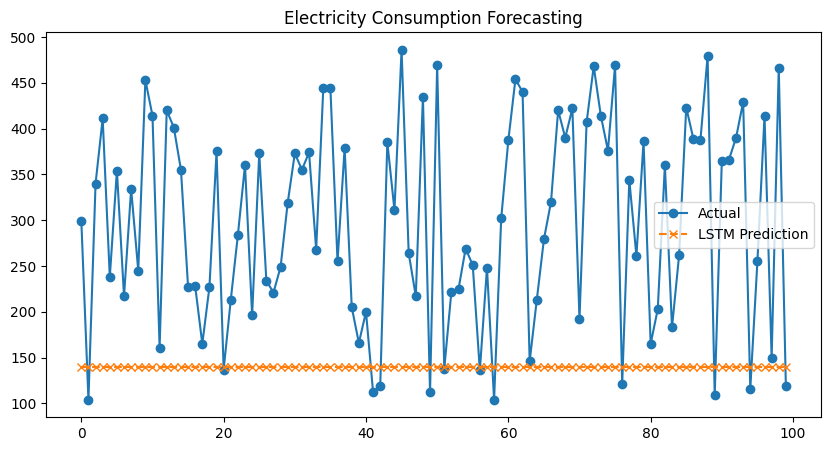

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test_lstm[:100], label="Actual", marker="o")
plt.plot(lstm_preds[:100], label="LSTM Prediction", linestyle="dashed", marker="x")
plt.legend()
plt.title("Electricity Consumption Forecasting")
plt.show()


C:\Users\muham\AppData\Local\Temp\ipykernel_22800\1709367358.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekly_consumption.index, y=weekly_consumption.values, palette="viridis")


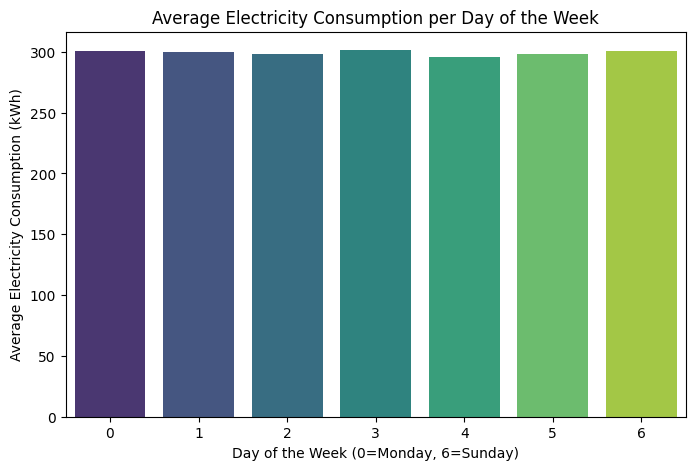

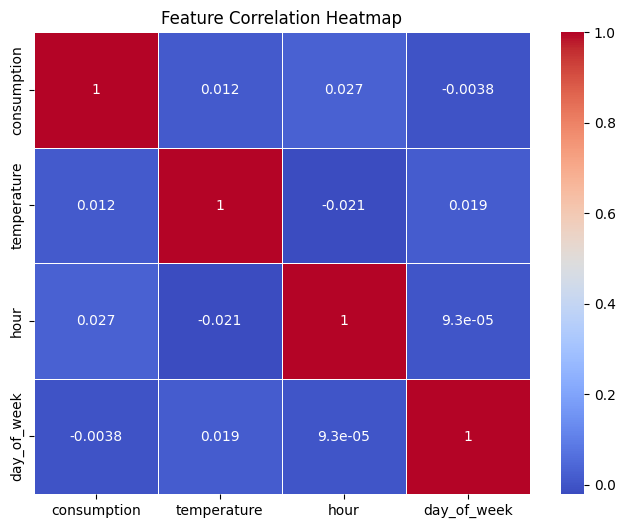

In [16]:
# Recalculate missing time-based features
df["hour"] = df["timestamp"].dt.hour
df["day_of_week"] = df["timestamp"].dt.dayofweek

# Recalculate weekly consumption
weekly_consumption = df.groupby("day_of_week")["consumption"].mean()

# Bar Chart: Average electricity consumption per day of the week
plt.figure(figsize=(8, 5))
sns.barplot(x=weekly_consumption.index, y=weekly_consumption.values, palette="viridis")
plt.xlabel("Day of the Week (0=Monday, 6=Sunday)")
plt.ylabel("Average Electricity Consumption (kWh)")
plt.title("Average Electricity Consumption per Day of the Week")
plt.show()

# Heatmap: Correlation between features
plt.figure(figsize=(8, 6))
sns.heatmap(df[["consumption", "temperature", "hour", "day_of_week"]].corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()
